In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import data_catalog
import tseries_mod
import esmlab_wrap

In [2]:
data_catalog.set_catalog('experiments')

active catalog: experiments


In [3]:
varnames = ['FG_CO2', 'FG_ALT_CO2', 'POC_FLUX_100m']

In [4]:
experiment = 'historical'
ds_expr_ann = tseries_mod.tseries_get_vars(varnames, 'ocn', experiment, freq='ann')
# print(ds_expr_ann)

In [5]:
# load Dataset for corresponding parent_experiment
parent_experiment = data_catalog.find_in_index(experiment=experiment).parent_experiment.unique()[0]
print(parent_experiment)
ds_parent_ann = tseries_mod.tseries_get_vars(varnames, 'ocn', parent_experiment, freq='ann')
# print(ds_parent_ann)

piControl


In [6]:
# add FG_ANTH_CO2 to datasets
for ds in [ds_expr_ann, ds_parent_ann]:
    ds['FG_ANTH_CO2'] = ds['FG_CO2'] - ds['FG_ALT_CO2']
# print(ds_expr_ann)
# print(ds_parent_ann)
varnames.append('FG_ANTH_CO2')

In [7]:
# construct year range of parent_experiment to use for detrending
branch_years = data_catalog.find_in_index(experiment=experiment).parent_branch_year.unique()
yr_lo = branch_years.min() - 50
yyyymmdd_lo = str(int(yr_lo)).zfill(4)+'-01-01'
yr_hi = branch_years.max() + 50 + len(ds_expr_ann.time)
yyyymmdd_hi = str(int(yr_hi)).zfill(4)+'-01-01'
print((yyyymmdd_lo, yyyymmdd_hi))

('0451-01-01', '1086-01-01')


In [8]:
# compute parent_experiment mean, for detrending
ds_parent_ann_slice_mean = ds_parent_ann.sel(time=slice(yyyymmdd_lo, yyyymmdd_hi)).mean(dim='time')
print(ds_parent_ann_slice_mean.FG_CO2)
print(ds_parent_ann_slice_mean.FG_ALT_CO2)
print(ds_parent_ann_slice_mean.FG_ANTH_CO2)
print(ds_parent_ann_slice_mean.POC_FLUX_100m)

<xarray.DataArray 'FG_CO2' (region: 7)>
array([-0.04368616,  0.22515085, -0.18012401,  0.5180596 , -1.0065866 ,
        0.3591652 ,  0.2658006 ], dtype=float32)
Coordinates:
  * region   (region) object 'Global' ... 'NH_high_lat (49N-90N)'
Attributes:
    long_name:     Integrated DIC Surface Gas Flux
    units:         Pg yr-1
    grid_loc:      2110
    cell_methods:  time: mean
<xarray.DataArray 'FG_ALT_CO2' (region: 7)>
array([-0.04368616,  0.22515085, -0.18012401,  0.5180596 , -1.0065866 ,
        0.3591652 ,  0.2658006 ], dtype=float32)
Coordinates:
  * region   (region) object 'Global' ... 'NH_high_lat (49N-90N)'
Attributes:
    long_name:     Integrated DIC Surface Gas Flux, Alternative CO2
    units:         Pg yr-1
    grid_loc:      2110
    cell_methods:  time: mean
<xarray.DataArray 'FG_ANTH_CO2' (region: 7)>
array([0., 0., 0., 0., 0., 0., 0.], dtype=float32)
Coordinates:
  * region   (region) object 'Global' ... 'NH_high_lat (49N-90N)'
Attributes:
    long_name:     Integ

In [9]:
ds_expr_ann_detrended = ds_expr_ann - ds_parent_ann_slice_mean

In [10]:
# add cummulate flux vars to datasets
for ds in [ds_expr_ann, ds_expr_ann_detrended]:
    for varname in varnames:
        da = ds[varname].cumsum(dim='time', keep_attrs=True)
        da.name = varname+'_CUM'
        da.attrs['units'] = 'Pg'
        ds[da.name] = da

# print(ds_expr_ann)
# print(ds_expr_ann_detrended)

array([129.00084 , 128.35834 , 126.256744, 129.25368 , 127.98231 ,
       129.72098 , 127.18066 , 127.09156 , 128.71136 , 126.317986,
       126.130936], dtype=float32)

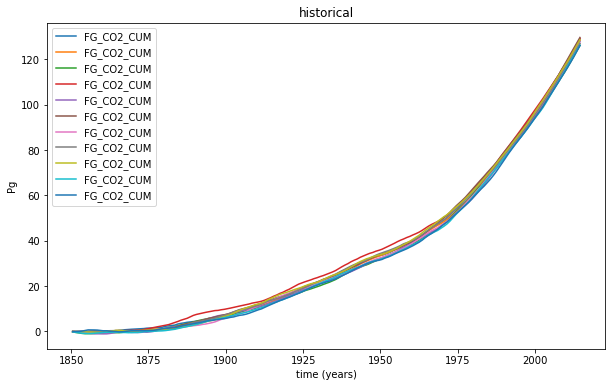

In [11]:
tseries_mod.tseries_plot_1ds(ds_expr_ann, ['FG_CO2_CUM'], title=experiment, region_val='Global')
ds_expr_ann['FG_CO2_CUM'].sel(region='Global').isel(time=-1).values

array([131.64586, 131.65279, 131.98705, 131.66435, 131.73016, 131.76118,
       131.71994, 131.8997 , 131.49689, 131.66406, 131.81258],
      dtype=float32)

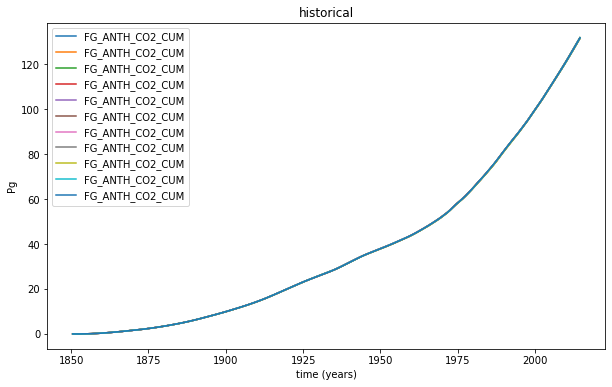

In [12]:
tseries_mod.tseries_plot_1ds(ds_expr_ann, ['FG_ANTH_CO2_CUM'], title=experiment, region_val='Global')
ds_expr_ann['FG_ANTH_CO2_CUM'].sel(region='Global').isel(time=-1).values

array([136.20906, 135.56657, 133.46494, 136.46191, 135.1905 , 136.92918,
       134.38889, 134.29977, 135.91959, 133.5262 , 133.33916],
      dtype=float32)

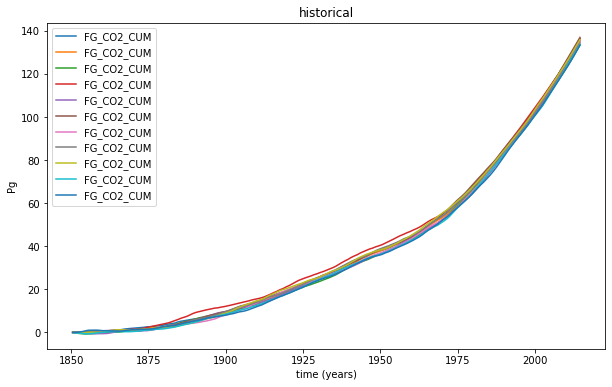

In [13]:
tseries_mod.tseries_plot_1ds(ds_expr_ann_detrended, ['FG_CO2_CUM'], title=experiment, region_val='Global')
ds_expr_ann_detrended['FG_CO2_CUM'].sel(region='Global').isel(time=-1).values

array([131.64586, 131.65279, 131.98705, 131.66435, 131.73016, 131.76118,
       131.71994, 131.8997 , 131.49689, 131.66406, 131.81258],
      dtype=float32)

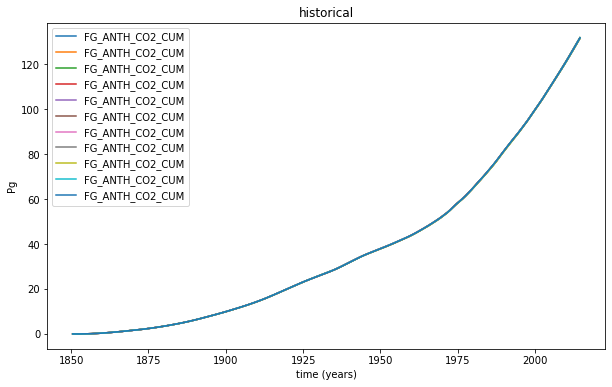

In [14]:
tseries_mod.tseries_plot_1ds(ds_expr_ann_detrended, ['FG_ANTH_CO2_CUM'], title=experiment, region_val='Global')
ds_expr_ann_detrended['FG_ANTH_CO2_CUM'].sel(region='Global').isel(time=-1).values

array([4.563163 , 3.9138417, 1.4778796, 4.7975407, 3.4603145, 5.1679826,
       2.6689394, 2.4000905, 4.422661 , 1.862133 , 1.5265914],
      dtype=float32)

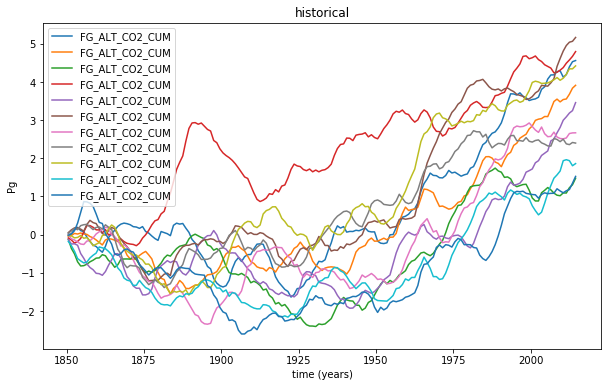

In [15]:
tseries_mod.tseries_plot_1ds(ds_expr_ann_detrended, ['FG_ALT_CO2_CUM'], title=experiment, region_val='Global')
ds_expr_ann_detrended['FG_ALT_CO2_CUM'].sel(region='Global').isel(time=-1).values

array([-2.6450522, -3.2943742, -5.730338 , -2.4106731, -3.7479017,
       -2.0402343, -4.5392756, -4.808125 , -2.7855532, -5.3460827,
       -5.6816244], dtype=float32)

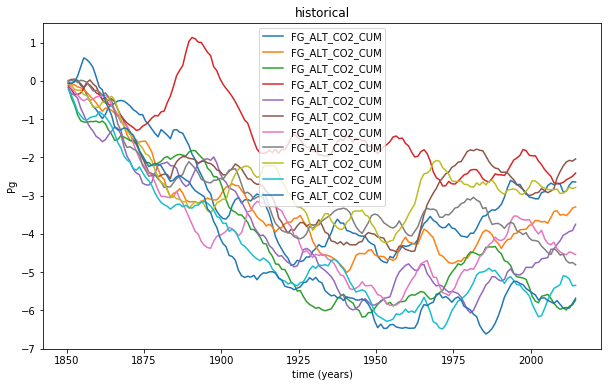

In [16]:
tseries_mod.tseries_plot_1ds(ds_expr_ann, ['FG_ALT_CO2_CUM'], title=experiment, region_val='Global')
ds_expr_ann['FG_ALT_CO2_CUM'].sel(region='Global').isel(time=-1).values

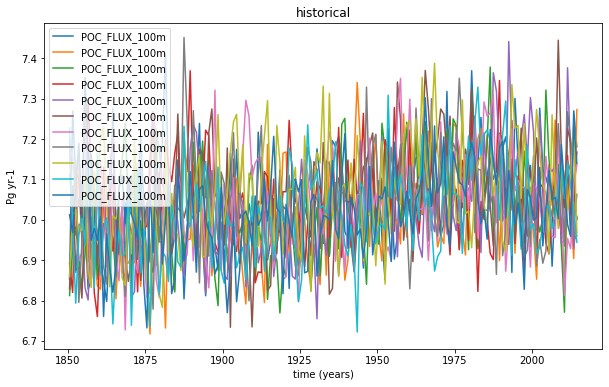

In [17]:
tseries_mod.tseries_plot_1ds(ds_expr_ann, ['POC_FLUX_100m'], title=experiment, region_val='Global')

array([ 6.8714876,  1.4176536,  4.0041347,  7.1893086,  5.6313562,
        7.086459 ,  5.6083684,  6.9124985, 10.23642  ,  2.3834014,
        3.5669785], dtype=float32)

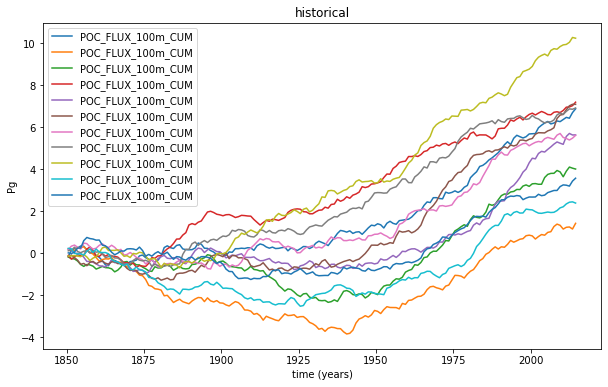

In [18]:
tseries_mod.tseries_plot_1ds(ds_expr_ann_detrended, ['POC_FLUX_100m_CUM'], title=experiment, region_val='Global')
ds_expr_ann_detrended['POC_FLUX_100m_CUM'].sel(region='Global').isel(time=-1).values